In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Load Data

In [ ]:
# Find the latest experiment directory
exp_dir = './experiments'
subdirs = [d for d in os.listdir(exp_dir) if d.startswith('alpha_stats_full')]
latest_subdir = sorted(subdirs)[-1]
output_dir = os.path.join(exp_dir, latest_subdir)

# Manually set experiment dir
subdir = 'alpha_stats_full_07075424'
output_dir = os.path.join(exp_dir, subdir)

print(f"Loading data from: {output_dir}")

# List all files
files = [f for f in os.listdir(output_dir) if f.endswith('.pt')]
print(f"Found {len(files)} files")
print(f"Files: {files[:5]}..." if len(files) > 5 else f"Files: {files}")

Loading data from: ./experiments/alpha_stats_full_07090749
Found 67 files
Files: ['5a7bb1315542997c3ec97253.pt', '5ae03a3655429942ec259c50.pt', '5ab77e6655429928e1fe385d.pt', '5ab67b7155429954757d32ef.pt', '5a8234c8554299676cceb22a.pt']...


In [150]:
# Load first file to inspect
first_file = os.path.join(output_dir, files[1])
data = torch.load(first_file)

print("Data structure:")
for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {list(value.shape)} ({value.dtype})")
    else:
        print(f"  {key}: {value}")

Data structure:
  alpha_mean: [48, 72, 64, 64] (torch.float32)
  alpha_var: [48, 72, 64, 64] (torch.float32)
  doc2_id: 5ae03a3655429942ec259c50
  num_doc1_samples: 1000
  max_doc2_len: 72
  n_layer: 48
  nheads: 64
  headdim: 64
  note: alpha_mean shape: [n_layer, max_doc2_len, nheads, headdim]. Only doc2 tokens are included.


## 2. Visualize Alpha Mean - Heatmaps

Visualize how attention weights vary across layers and sequence positions for different heads.

In [151]:
alpha_mean = data['alpha_mean']  # [n_layer, seqlen, nheads, headdim]
alpha_var = data['alpha_var']

n_layer, seqlen, nheads, headdim = alpha_mean.shape
print(f"Shape: [layers={n_layer}, seqlen={seqlen}, heads={nheads}, headdim={headdim}]")

Shape: [layers=48, seqlen=72, heads=64, headdim=64]


In [152]:
# Average across head dimensions to get [n_layer, seqlen, nheads]
alpha_mean_avg = alpha_mean.mean(dim=-1).numpy()  # [n_layer, seqlen, nheads]

# Use all heads instead of random selection
all_heads = list(range(nheads))
print(f"Visualizing all {nheads} heads")

Visualizing all 64 heads


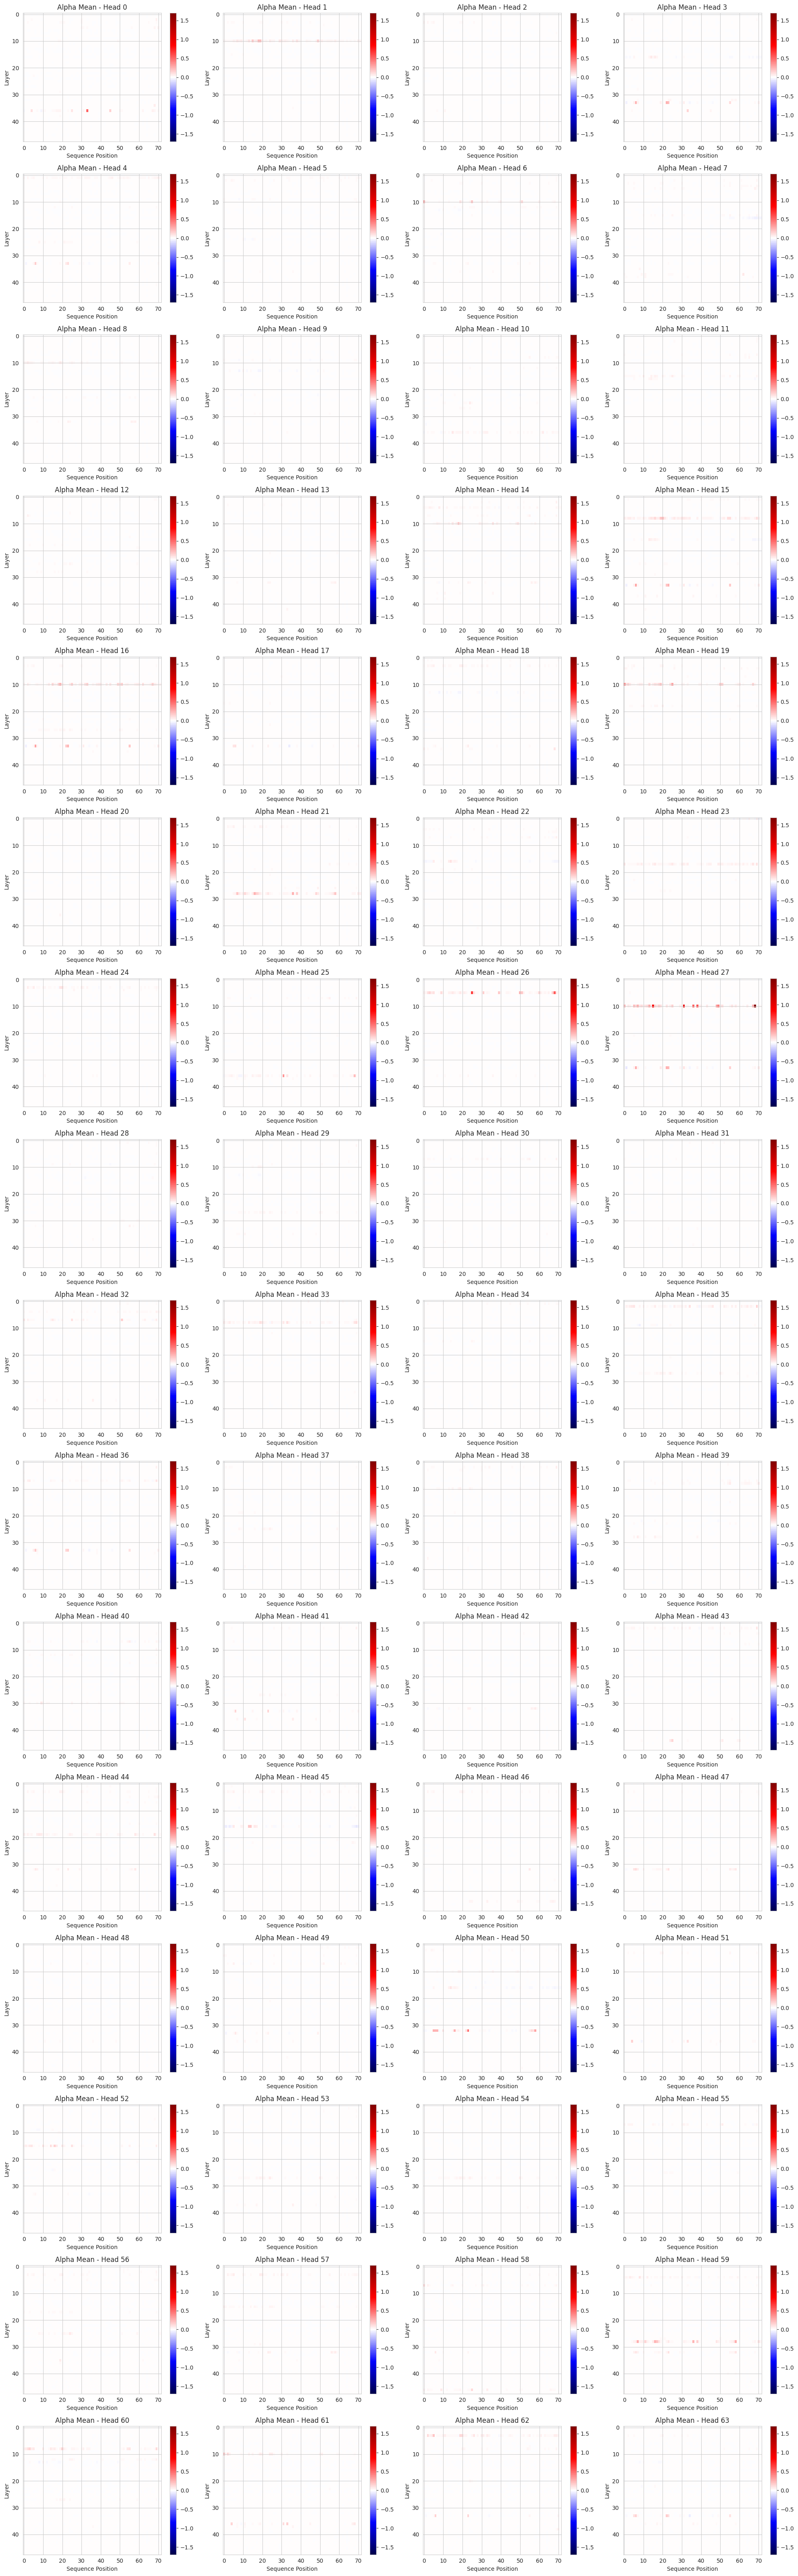

Saved: ./experiments/alpha_stats_full_07090749_alpha_mean_heatmaps.png


In [153]:
# Plot heatmaps for all heads (4 per row)
from matplotlib.colors import TwoSlopeNorm

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Find global min/max and create symmetric scale around 0
vmax = max(abs(alpha_mean_avg.min()), abs(alpha_mean_avg.max()))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_mean_avg[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='seismic', 
                                interpolation='nearest', norm=norm)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha Mean - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_mean_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_mean_heatmaps.png")

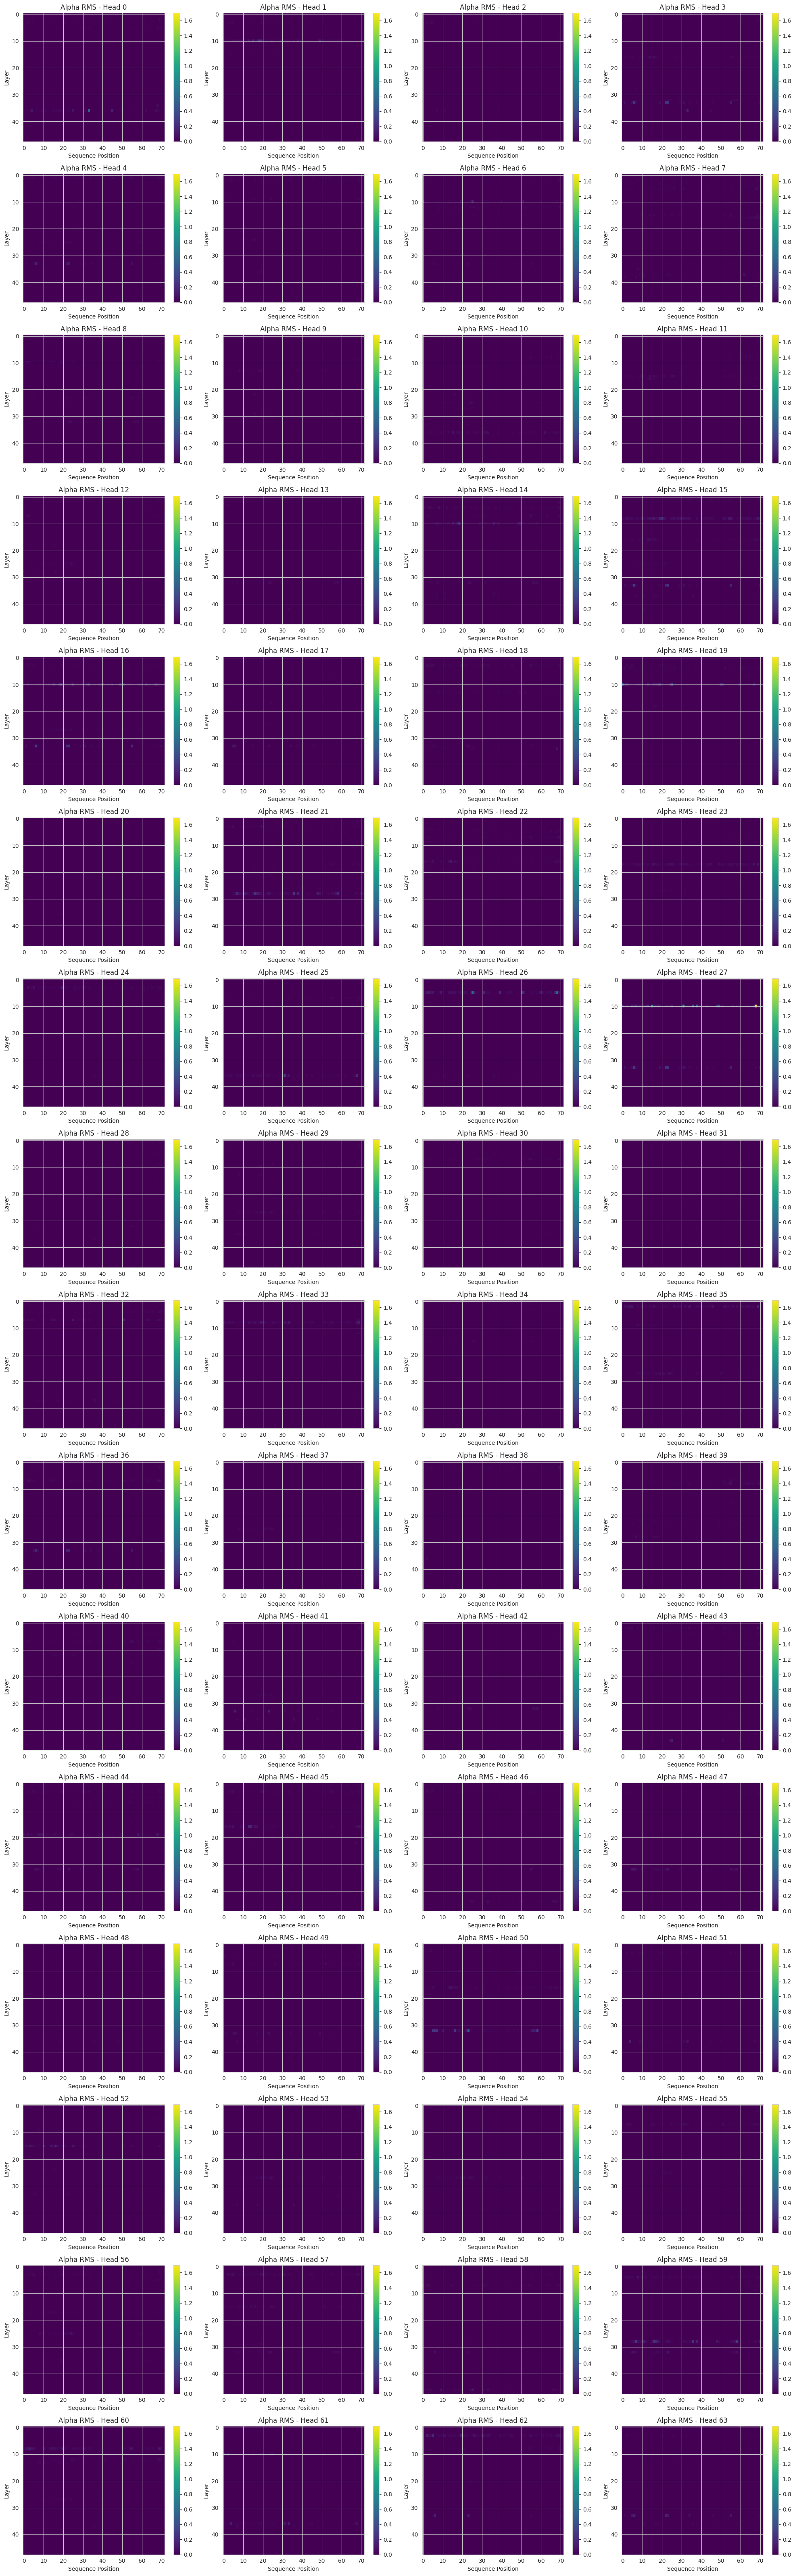

Saved: ./experiments/alpha_stats_full_07090749_alpha_rms_heatmaps.png


In [154]:
# Plot RMS heatmaps for all heads (4 per row)
# RMS (Root Mean Square) over headdim dimension
alpha_mean_rms = torch.sqrt((alpha_mean ** 2).mean(dim=-1)).numpy()  # [n_layer, seqlen, nheads]

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Find global min/max for consistent color scale
vmin_rms = alpha_mean_rms.min()
vmax_rms = alpha_mean_rms.max()

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_mean_rms[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='viridis', 
                                interpolation='nearest', vmin=vmin_rms, vmax=vmax_rms)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha RMS - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_rms_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_rms_heatmaps.png")

Alpha flat shape: torch.Size([48, 72, 4096])
Alpha flat mean shape: (48, 72)
Alpha flat RMS shape: (48, 72)


/root/autodl-tmp/tmp/ipykernel_170548/4174024630.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ./experiments/alpha_stats_full_07090749_alpha_flat_reduced.png


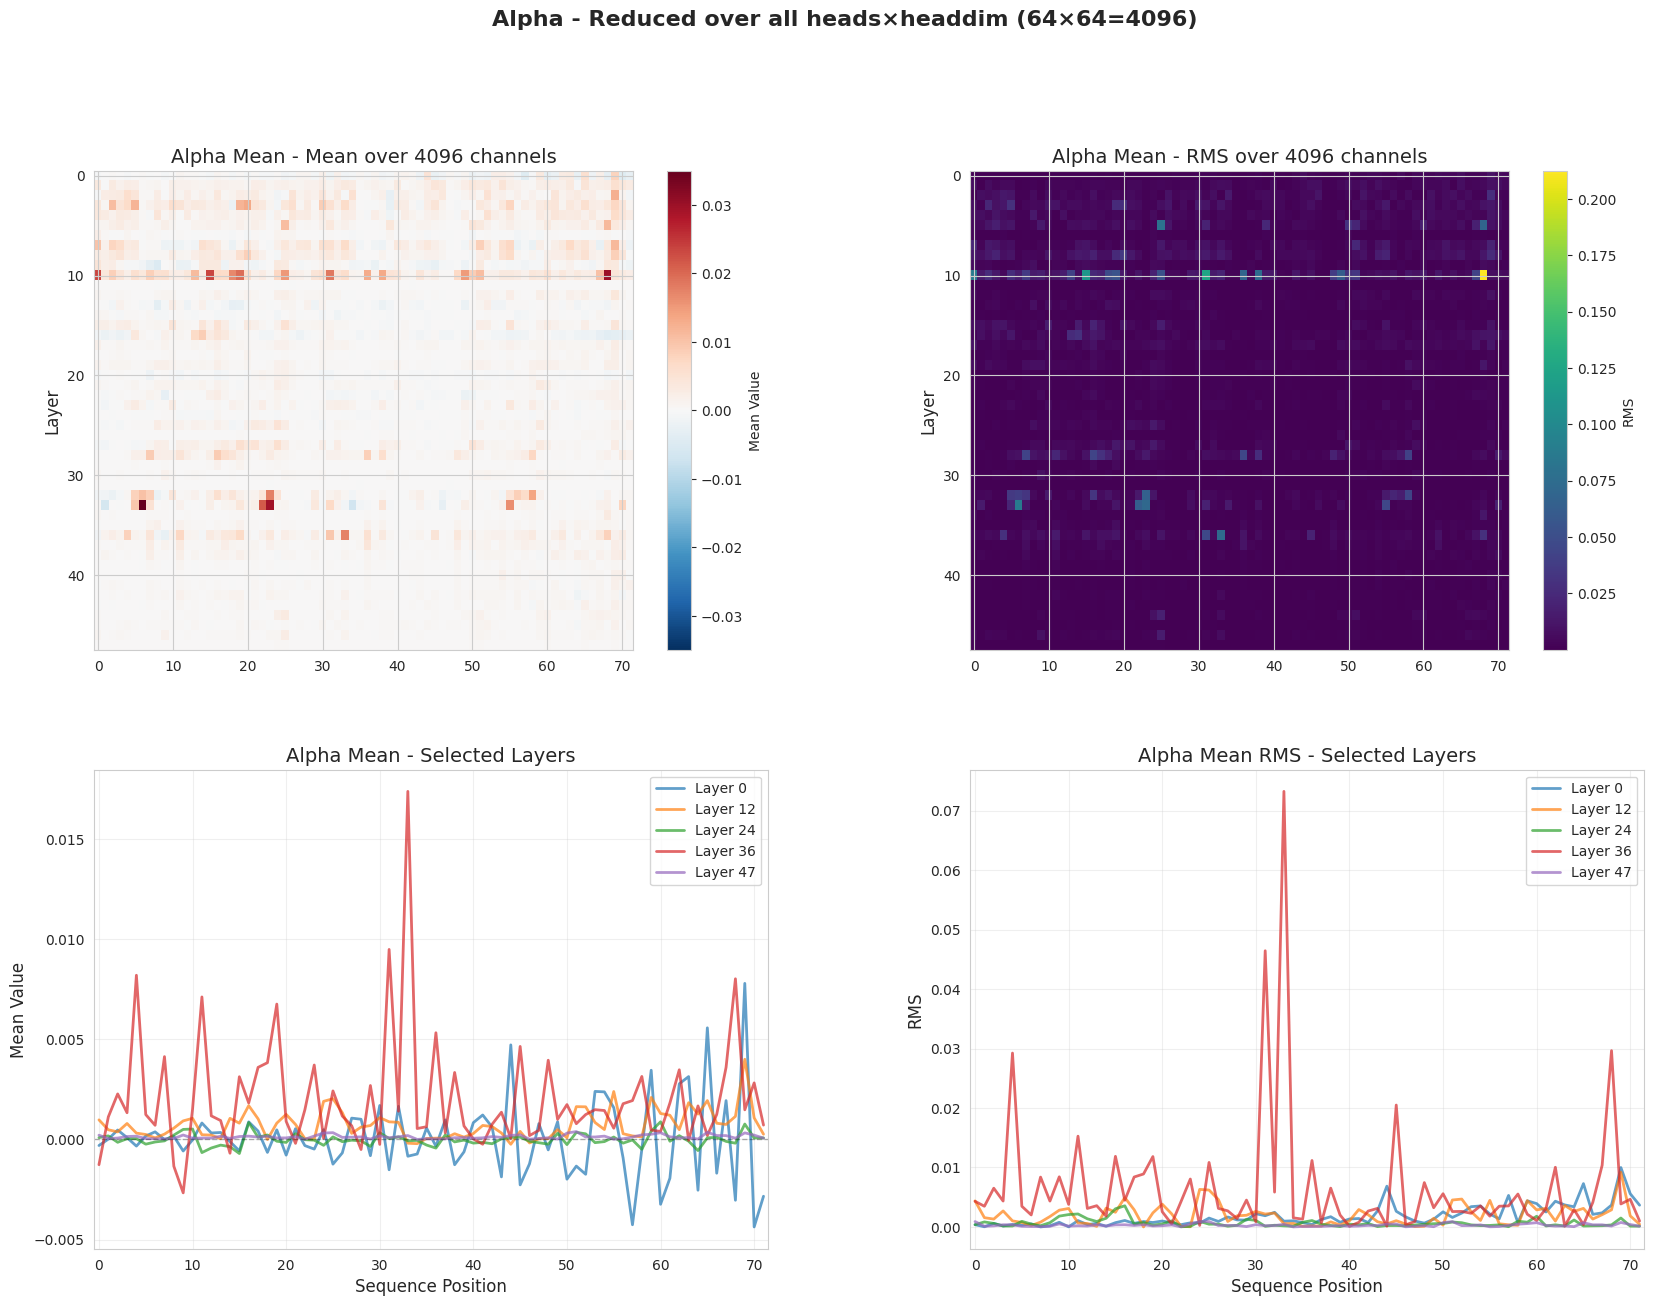

In [155]:
# Flatten last two dimensions (nheads * headdim) and reduce
# alpha_mean: [n_layer, seqlen, nheads, headdim] -> [n_layer, seqlen, nheads*headdim]
alpha_flat = alpha_mean.reshape(n_layer, seqlen, -1)  # [n_layer, seqlen, 1536]

# Calculate mean and RMS over the flattened dimension
alpha_flat_mean = alpha_flat.mean(dim=-1).cpu().numpy()  # [n_layer, seqlen]
alpha_flat_rms = torch.sqrt((alpha_flat ** 2).mean(dim=-1)).cpu().numpy()  # [n_layer, seqlen]

print(f"Alpha flat shape: {alpha_flat.shape}")
print(f"Alpha flat mean shape: {alpha_flat_mean.shape}")
print(f"Alpha flat RMS shape: {alpha_flat_rms.shape}")

# Select some layers for line plots
selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Alpha - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap
vmax_mean = max(abs(alpha_flat_mean.min()), abs(alpha_flat_mean.max()))
im1 = axes[0, 0].imshow(alpha_flat_mean, aspect='auto', cmap='RdBu_r', 
                        interpolation='nearest', vmin=-vmax_mean, vmax=vmax_mean)
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_title(f'Alpha Mean - Mean over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean Value')

# Top Right: RMS Heatmap
im2 = axes[0, 1].imshow(alpha_flat_rms, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_title(f'Alpha Mean - RMS over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(alpha_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1, 0].set_xlabel('Sequence Position', fontsize=12)
axes[1, 0].set_ylabel('Mean Value', fontsize=12)
axes[1, 0].set_title('Alpha Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(alpha_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Sequence Position', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Alpha Mean RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig(f'{output_dir}_alpha_flat_reduced.png', dpi=150, bbox_inches='tight')
print(f"Saved: {output_dir}_alpha_flat_reduced.png")
plt.show()

## 3. Visualize Alpha Variance - Heatmaps

Visualize how variance varies across layers and sequence positions for different heads.

In [156]:
# Average across head dimensions to get [n_layer, seqlen, nheads]
alpha_var_avg = alpha_var.mean(dim=-1).numpy()  # [n_layer, seqlen, nheads]

print(f"Visualizing variance for all {nheads} heads")

Visualizing variance for all 64 heads


In [ ]:
# Plot variance heatmaps for all heads (4 per row)
from matplotlib.colors import LogNorm

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Use log scale for variance (add small epsilon to avoid log(0))
epsilon = 1e-10
vmin_var = max(alpha_var_avg.min(), epsilon)
vmax_var = alpha_var_avg.max()

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_var_avg[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='hot', 
                                interpolation='nearest', norm=LogNorm(vmin=vmin_var, vmax=vmax_var))
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha Variance - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_var_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_var_heatmaps.png")

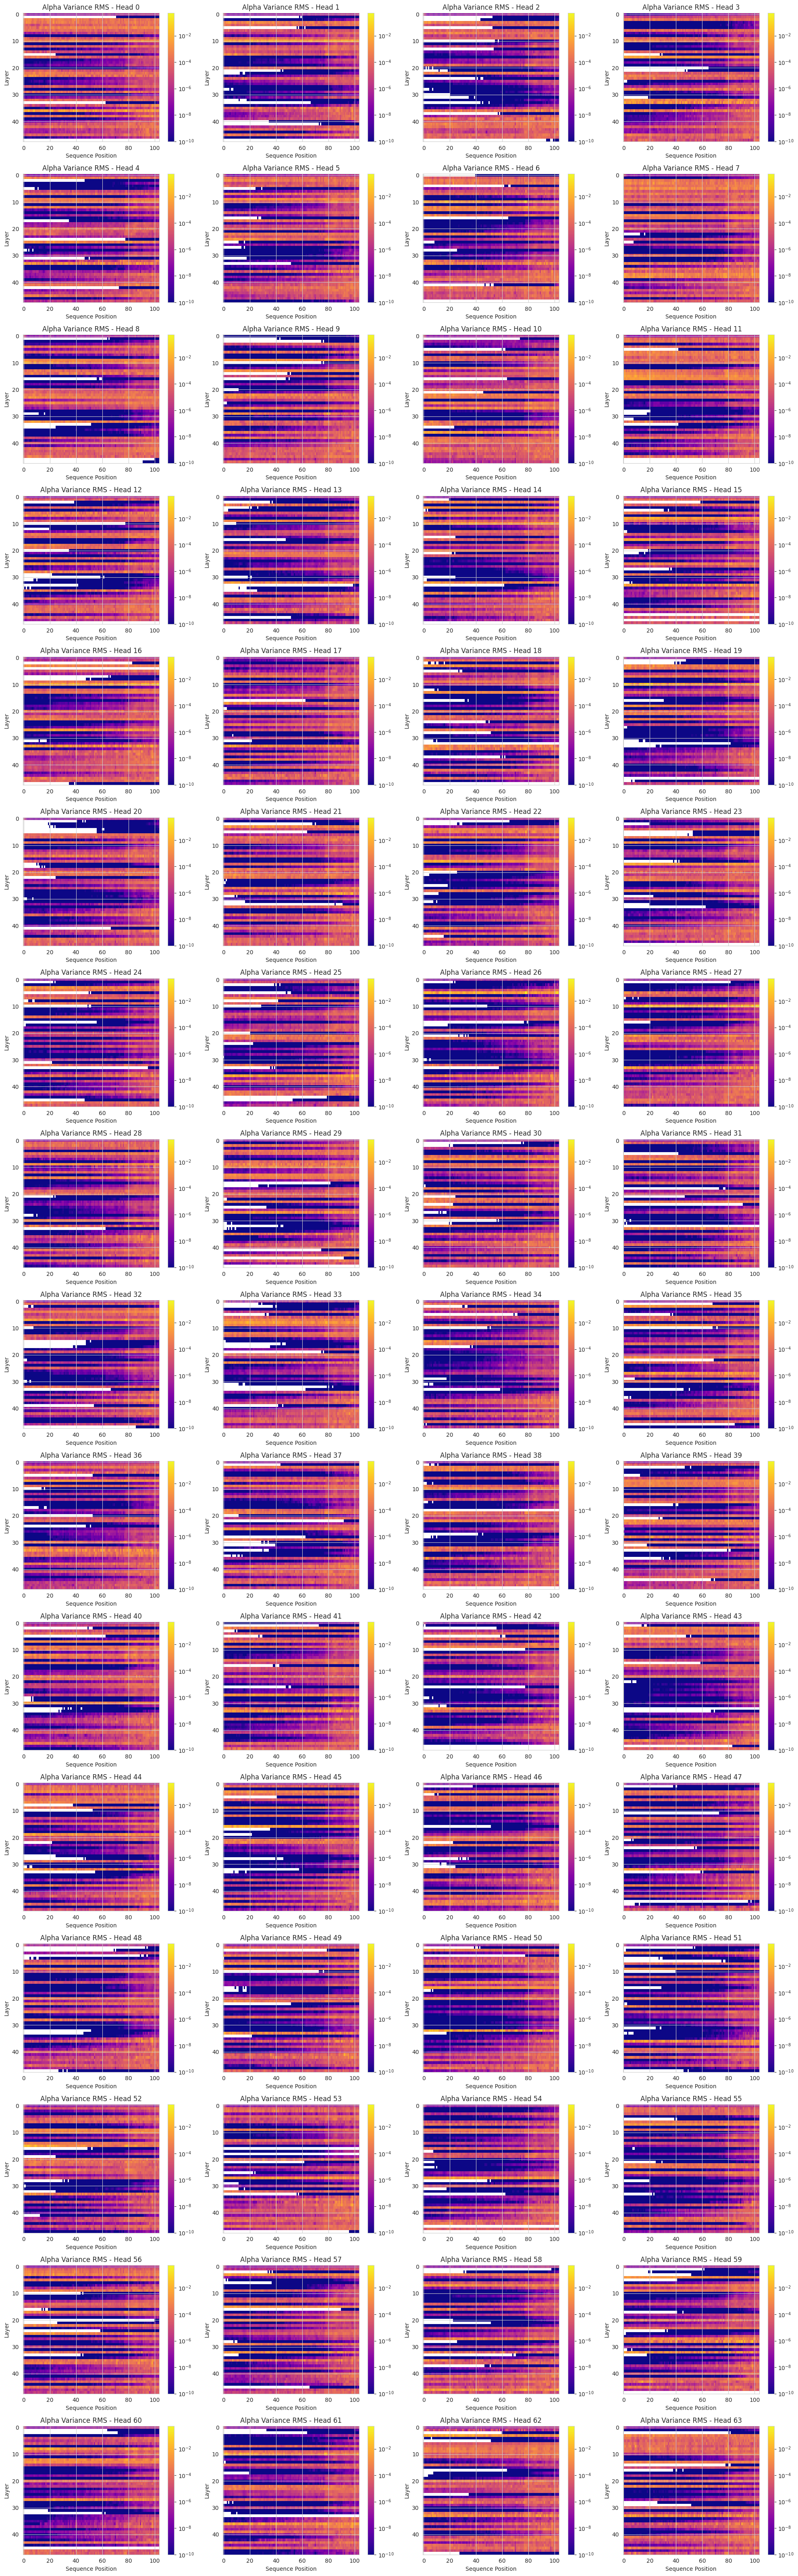

Saved: ./experiments/alpha_stats_full_07090749_alpha_var_rms_heatmaps.png


In [ ]:
# Plot RMS heatmaps for all heads (4 per row)
# RMS is sqrt of variance (i.e., standard deviation) averaged over headdim
# This is NOT sqrt((variance**2).mean()), but sqrt(variance.mean())
alpha_var_rms = np.sqrt(alpha_var.mean(dim=-1).numpy())  # [n_layer, seqlen, nheads]

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Use log scale for RMS (add small epsilon to avoid log(0))
epsilon = 1e-10
vmin_var_rms = max(alpha_var_rms.min(), epsilon)
vmax_var_rms = alpha_var_rms.max()

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_var_rms[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='plasma', 
                                interpolation='nearest', norm=LogNorm(vmin=vmin_var_rms, vmax=vmax_var_rms))
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha Variance RMS - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_var_rms_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_var_rms_heatmaps.png")

Alpha variance flat shape: torch.Size([48, 104, 4096])
Alpha variance flat mean shape: (48, 104)
Alpha variance flat RMS shape: (48, 104)


/root/autodl-tmp/tmp/ipykernel_170548/2727154668.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


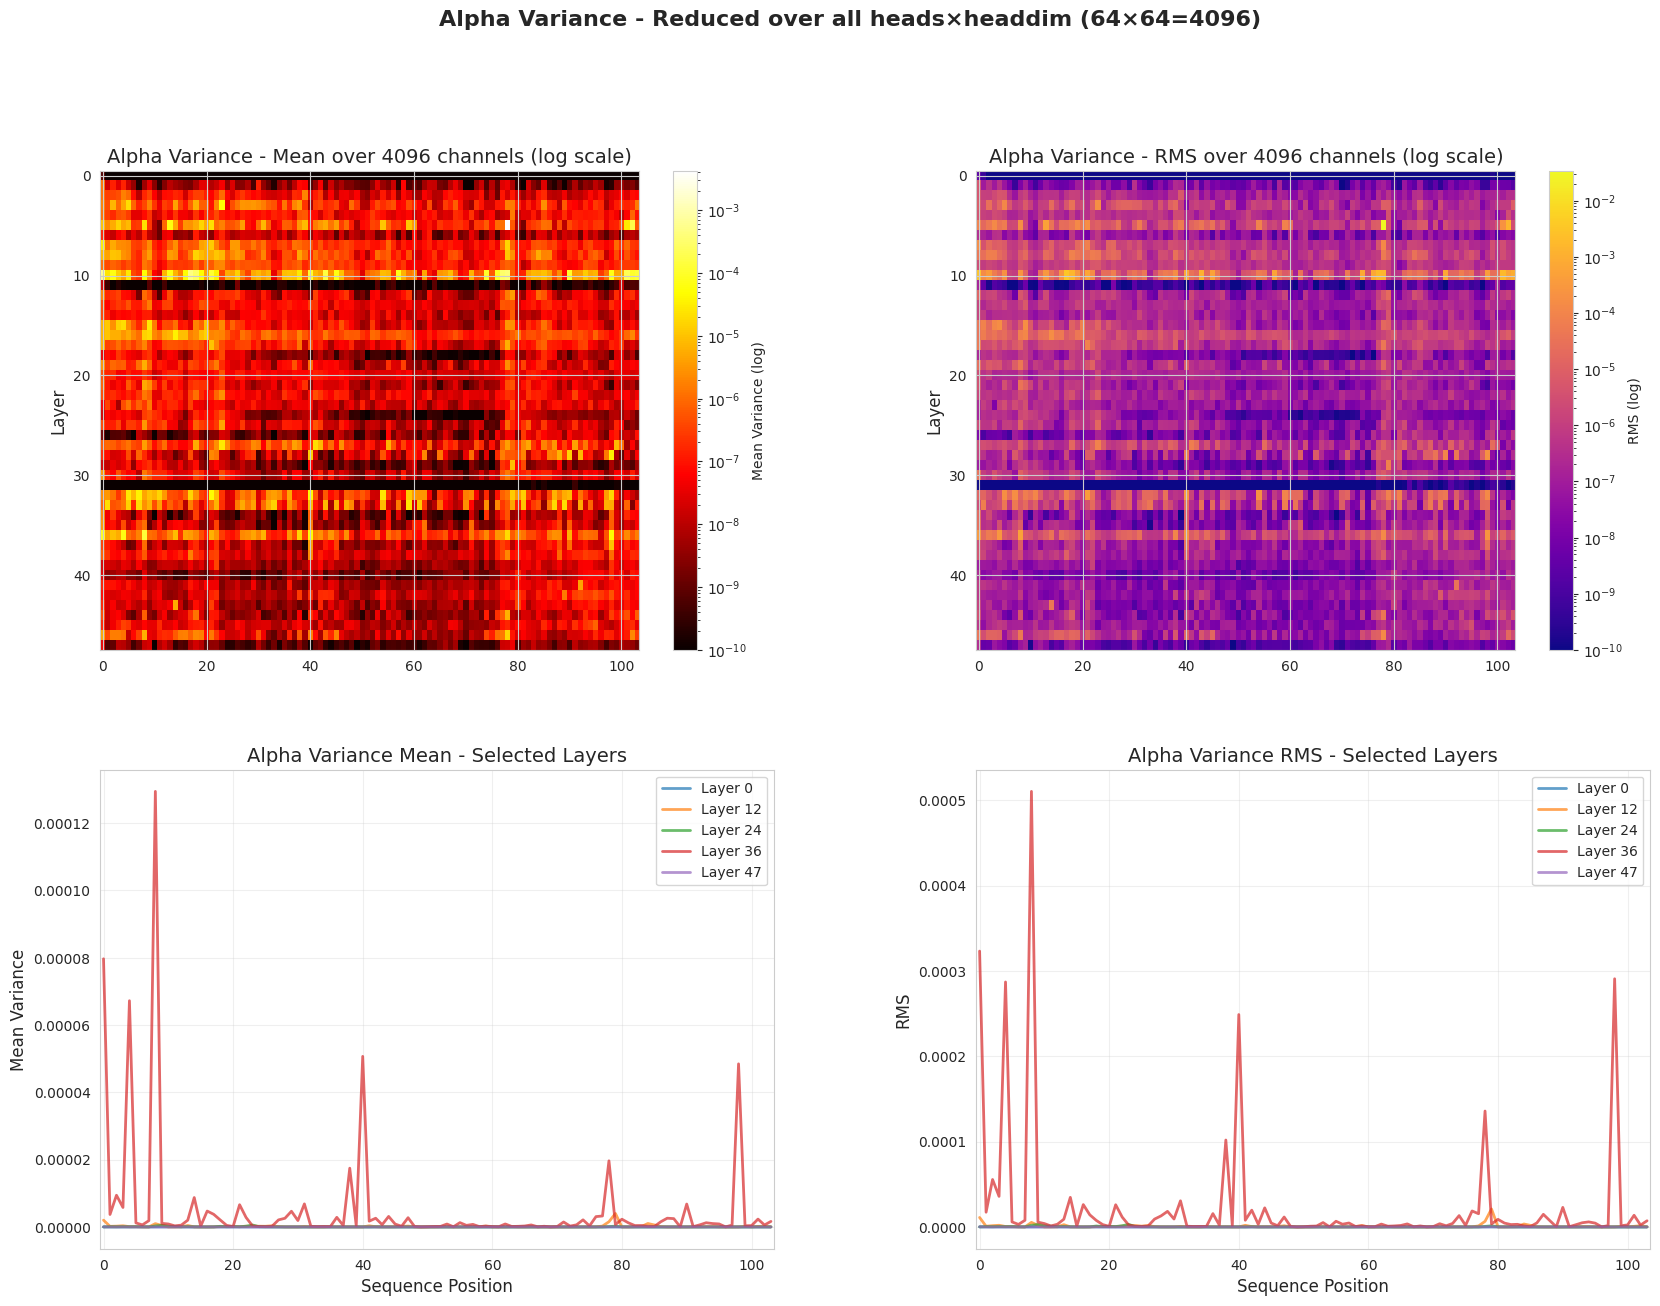

Saved: ./experiments/alpha_stats_full_07090749_alpha_var_flat_reduced.png


In [ ]:
from matplotlib.colors import LogNorm

# Flatten last two dimensions (nheads * headdim) and reduce
# alpha_var: [n_layer, seqlen, nheads, headdim] -> [n_layer, seqlen, nheads*headdim]
alpha_var_flat = alpha_var.reshape(n_layer, seqlen, -1)  # [n_layer, seqlen, 1536]

# Calculate mean and RMS over the flattened dimension
alpha_var_flat_mean = alpha_var_flat.mean(dim=-1).cpu().numpy()  # [n_layer, seqlen]
alpha_var_flat_rms = torch.sqrt((alpha_var_flat ** 2).mean(dim=-1)).cpu().numpy()  # [n_layer, seqlen]

print(f"Alpha variance flat shape: {alpha_var_flat.shape}")
print(f"Alpha variance flat mean shape: {alpha_var_flat_mean.shape}")
print(f"Alpha variance flat RMS shape: {alpha_var_flat_rms.shape}")

# Use selected_layers from Section 2 (reuse if already defined, otherwise define)
if 'selected_layers' not in locals():
    selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Alpha Variance - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap (use log scale for variance)
epsilon = 1e-10
vmin_var_flat = max(alpha_var_flat_mean.min(), epsilon)
vmax_var_flat = alpha_var_flat_mean.max()
im1 = axes[0, 0].imshow(alpha_var_flat_mean, aspect='auto', cmap='hot', 
                        interpolation='nearest', norm=LogNorm(vmin=vmin_var_flat, vmax=vmax_var_flat))
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_title(f'Alpha Variance - Mean over {nheads*headdim} channels (log scale)', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean Variance (log)')

# Top Right: RMS Heatmap (use log scale)
vmin_var_flat_rms = max(alpha_var_flat_rms.min(), epsilon)
vmax_var_flat_rms = alpha_var_flat_rms.max()
im2 = axes[0, 1].imshow(alpha_var_flat_rms, aspect='auto', cmap='plasma', interpolation='nearest',
                        norm=LogNorm(vmin=vmin_var_flat_rms, vmax=vmax_var_flat_rms))
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_title(f'Alpha Variance - RMS over {nheads*headdim} channels (log scale)', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS (log)')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(alpha_var_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('Sequence Position', fontsize=12)
axes[1, 0].set_ylabel('Mean Variance', fontsize=12)
axes[1, 0].set_title('Alpha Variance Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(alpha_var_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Sequence Position', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Alpha Variance RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)

axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_var_flat_reduced.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_var_flat_reduced.png")

## 4. Visualize Alpha CV (Coefficient of Variation) - Heatmaps

Visualize CV = std / mean for each point across layers and sequence positions for different heads.

In [ ]:
# Calculate coefficient of variation (CV) = std / |mean|
# CV measures relative variability, normalizing variance by the mean
# Add small epsilon to avoid division by zero
epsilon = 1e-8

# Calculate CV: std / |mean|
# alpha_var: [n_layer, seqlen, nheads, headdim]
# alpha_mean: [n_layer, seqlen, nheads, headdim]
alpha_std = torch.sqrt(alpha_var)
alpha_cv = alpha_std / (torch.abs(alpha_mean) + epsilon)

# Average across head dimensions to get [n_layer, seqlen, nheads]
alpha_cv_avg = alpha_cv.mean(dim=-1).numpy()


print(f"Alpha CV shape: {alpha_cv_avg.shape}")
print(f"CV mean: {alpha_cv_avg.mean():.4f}, median: {np.median(alpha_cv_avg):.4f}")
print(f"CV range: [{alpha_cv_avg.min():.4f}, {alpha_cv_avg.max():.4f}]")

Alpha CV shape: (48, 104, 64)
CV mean: 0.5798, median: 0.1844
CV range: [0.0000, 14656.3047]


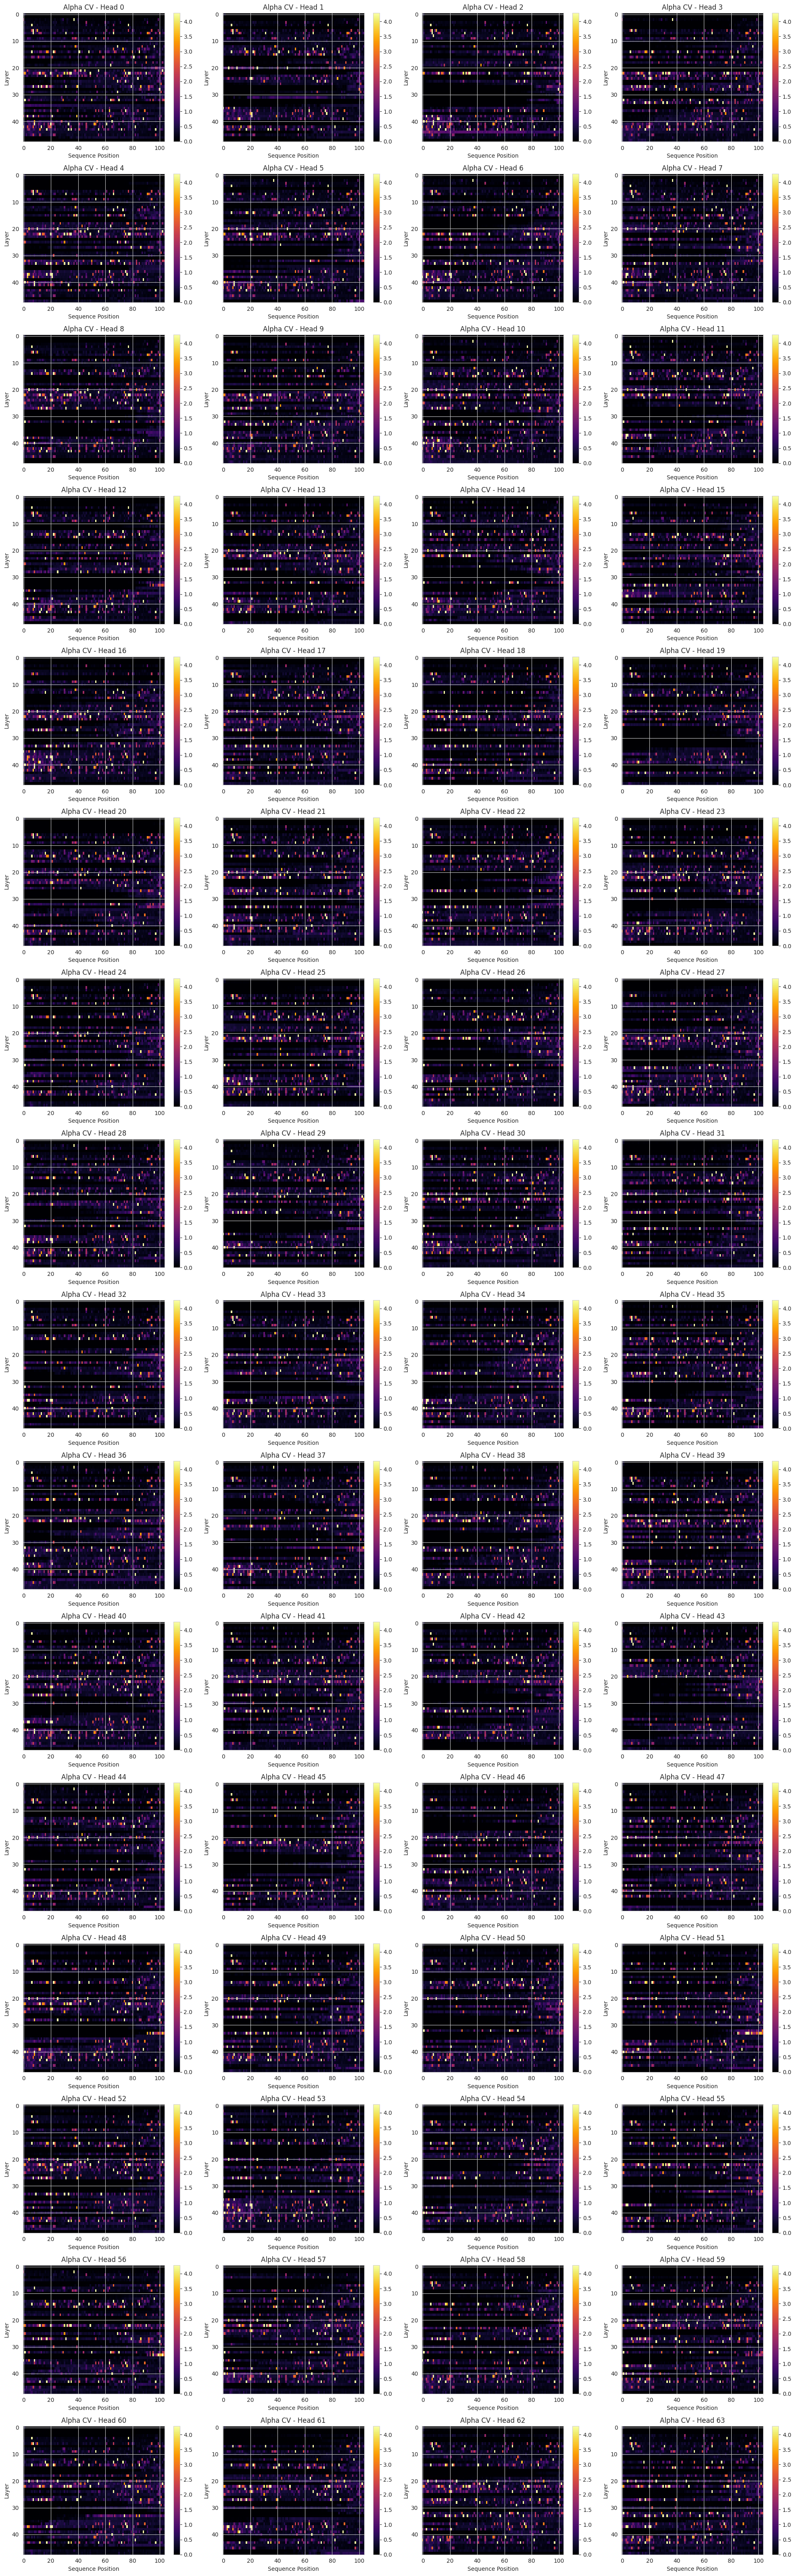

Saved: ./experiments/alpha_stats_full_07090749_alpha_cv_heatmaps.png


In [ ]:
# Plot CV heatmaps for all heads (4 per row)
# Use percentile-based color scaling to handle outliers
ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Calculate global percentile range for consistent color scaling
vmin_cv = np.percentile(alpha_cv_avg, 1)
vmax_cv = np.percentile(alpha_cv_avg, 99)

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_cv_avg[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='inferno', 
                                interpolation='nearest', vmin=vmin_cv, vmax=vmax_cv)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha CV - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_cv_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_cv_heatmaps.png")

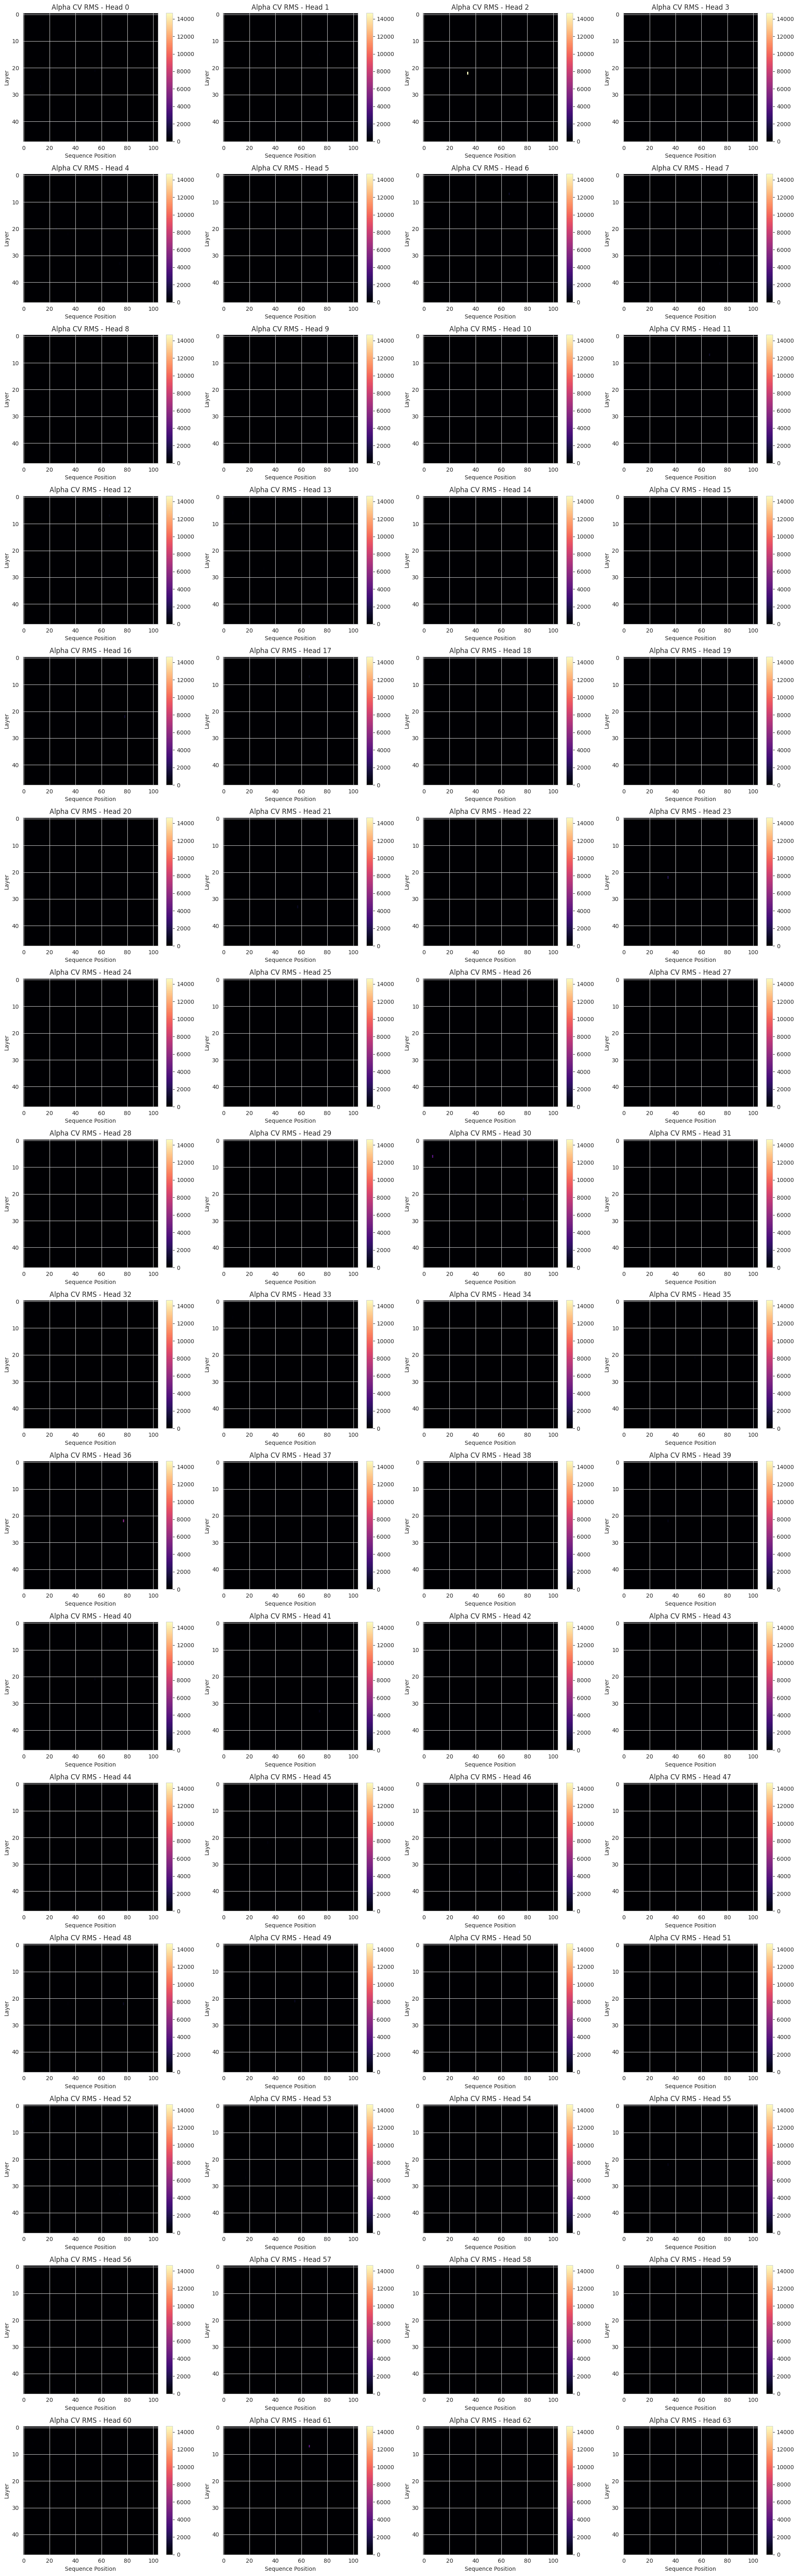

Saved: ./experiments/alpha_stats_full_07090749_alpha_cv_rms_heatmaps.png


In [ ]:
# Plot CV RMS heatmaps for all heads (4 per row)
# RMS (Root Mean Square) over headdim dimension
alpha_cv_rms = torch.sqrt((alpha_cv ** 2).mean(dim=-1)).numpy()  # [n_layer, seqlen, nheads]

ncols = 4
nrows = (nheads + ncols - 1) // ncols  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
if nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

# Find global min/max for consistent color scale
vmin_cv_rms = alpha_cv_rms.min()
vmax_cv_rms = alpha_cv_rms.max()

for idx, head_idx in enumerate(all_heads):
    # Get data for this head: [n_layer, seqlen]
    head_data = alpha_cv_rms[:, :, head_idx]
    
    im = axes_flat[idx].imshow(head_data, aspect='auto', cmap='magma', 
                                interpolation='nearest', vmin=vmin_cv_rms, vmax=vmax_cv_rms)
    axes_flat[idx].set_xlabel('Sequence Position')
    axes_flat[idx].set_ylabel('Layer')
    axes_flat[idx].set_title(f'Alpha CV RMS - Head {head_idx}')
    plt.colorbar(im, ax=axes_flat[idx])

# Hide extra subplots if nheads is not divisible by ncols
for idx in range(nheads, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}_alpha_cv_rms_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_alpha_cv_rms_heatmaps.png")

Alpha CV flat shape: torch.Size([48, 104, 4096])
Alpha CV flat mean shape: (48, 104)
Alpha CV flat RMS shape: (48, 104)
Saved: ./experiments/alpha_stats_full_07090749_alpha_cv_flat_reduced.png


/root/autodl-tmp/tmp/ipykernel_170548/2622920513.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


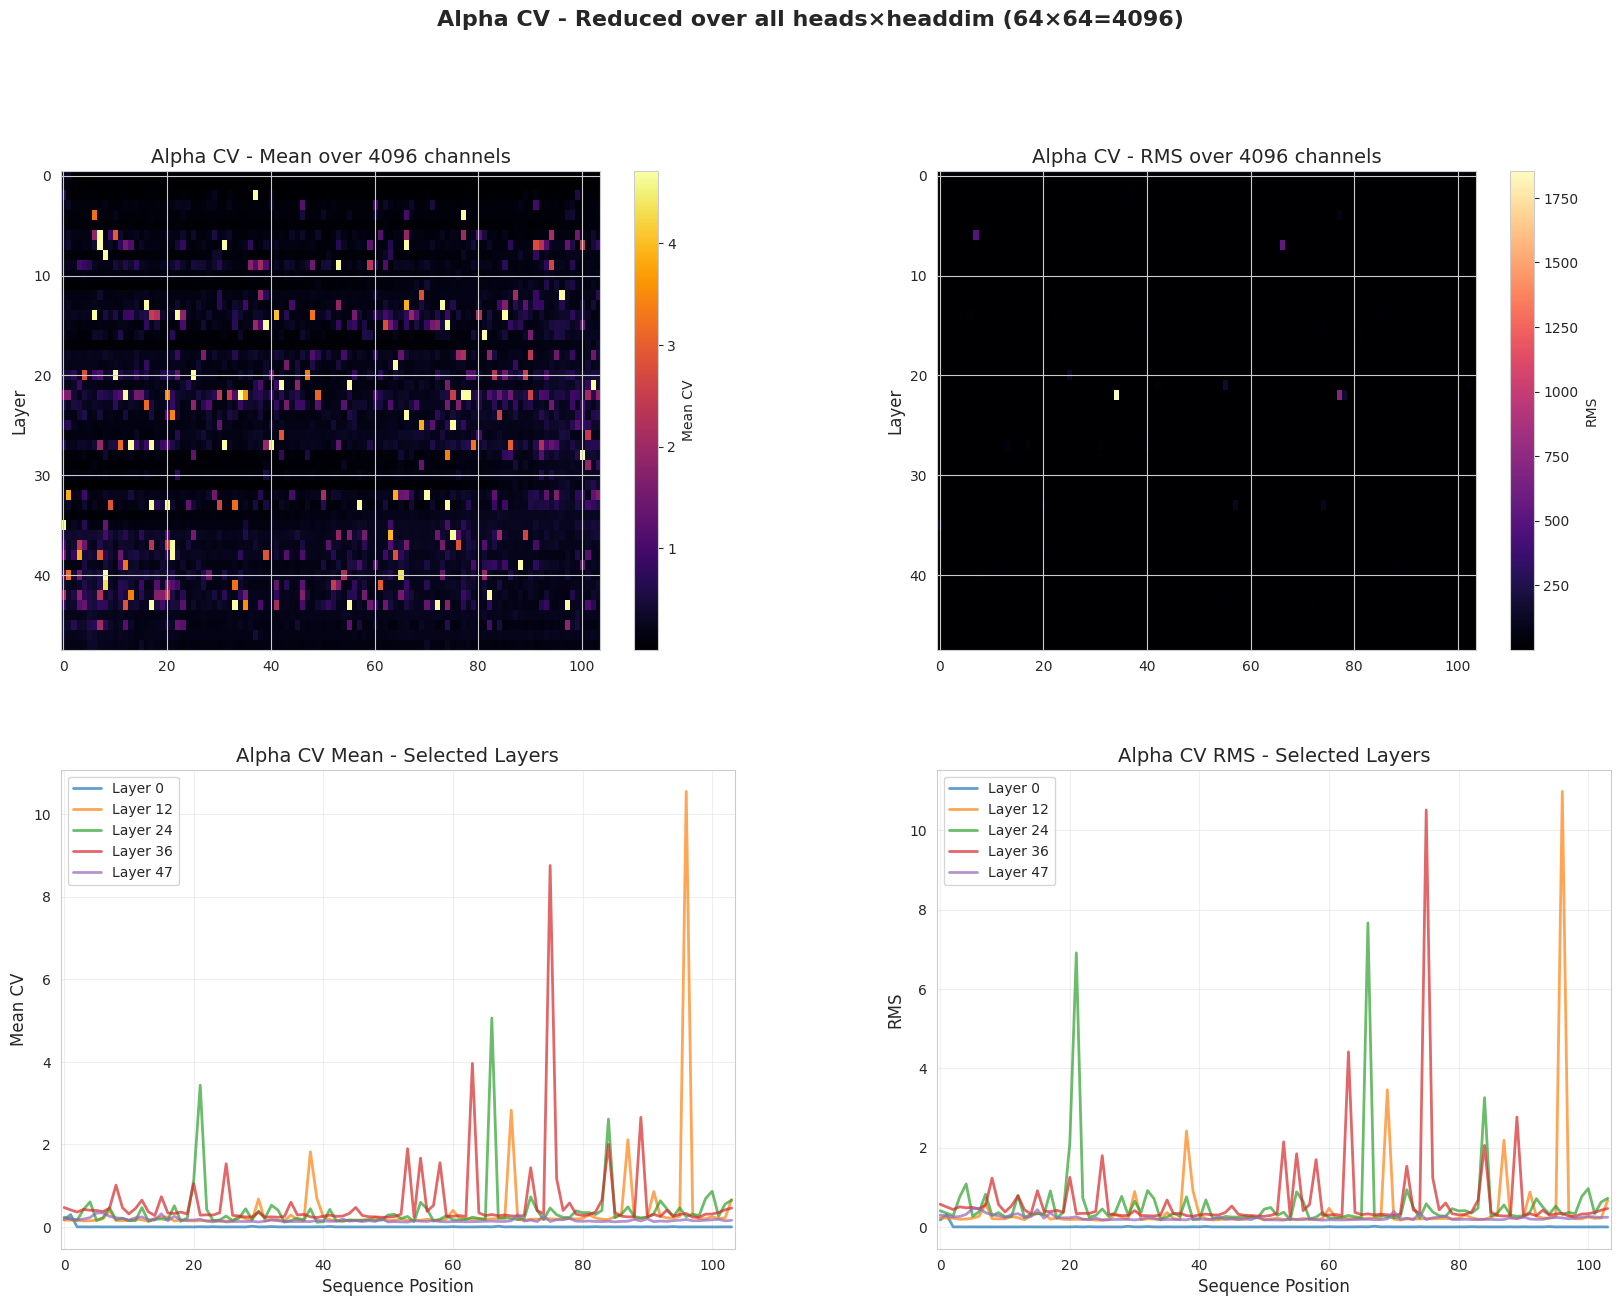

<Figure size 1500x800 with 0 Axes>

In [ ]:
# Flatten last two dimensions (nheads * headdim) and reduce
# alpha_cv: [n_layer, seqlen, nheads, headdim] -> [n_layer, seqlen, nheads*headdim]
alpha_cv_flat = alpha_cv.reshape(n_layer, seqlen, -1)  # [n_layer, seqlen, nheads*headdim]

# Calculate mean and RMS over the flattened dimension
alpha_cv_flat_mean = alpha_cv_flat.mean(dim=-1).cpu().numpy()  # [n_layer, seqlen]
alpha_cv_flat_rms = torch.sqrt((alpha_cv_flat ** 2).mean(dim=-1)).cpu().numpy()  # [n_layer, seqlen]

print(f"Alpha CV flat shape: {alpha_cv_flat.shape}")
print(f"Alpha CV flat mean shape: {alpha_cv_flat_mean.shape}")
print(f"Alpha CV flat RMS shape: {alpha_cv_flat_rms.shape}")

# Use selected_layers from Section 2 (reuse if already defined, otherwise define)
if 'selected_layers' not in locals():
    selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Alpha CV - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap (use percentile scaling)
vmin_cv_flat = np.percentile(alpha_cv_flat_mean, 1)
vmax_cv_flat = np.percentile(alpha_cv_flat_mean, 99)
im1 = axes[0, 0].imshow(alpha_cv_flat_mean, aspect='auto', cmap='inferno', 
                        interpolation='nearest', vmin=vmin_cv_flat, vmax=vmax_cv_flat)
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_title(f'Alpha CV - Mean over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean CV')

# Top Right: RMS Heatmap
im2 = axes[0, 1].imshow(alpha_cv_flat_rms, aspect='auto', cmap='magma', interpolation='nearest')
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_title(f'Alpha CV - RMS over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(alpha_cv_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('Sequence Position', fontsize=12)
axes[1, 0].set_ylabel('Mean CV', fontsize=12)
axes[1, 0].set_title('Alpha CV Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(alpha_cv_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Sequence Position', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Alpha CV RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

print(f"Saved: {output_dir}_alpha_cv_flat_reduced.png")

plt.tight_layout()
plt.show()
plt.savefig(f'{output_dir}_alpha_cv_flat_reduced.png', dpi=150, bbox_inches='tight')

## 5. Analyze Attention Patterns

Analyze which tokens receive the most attention from the last token.

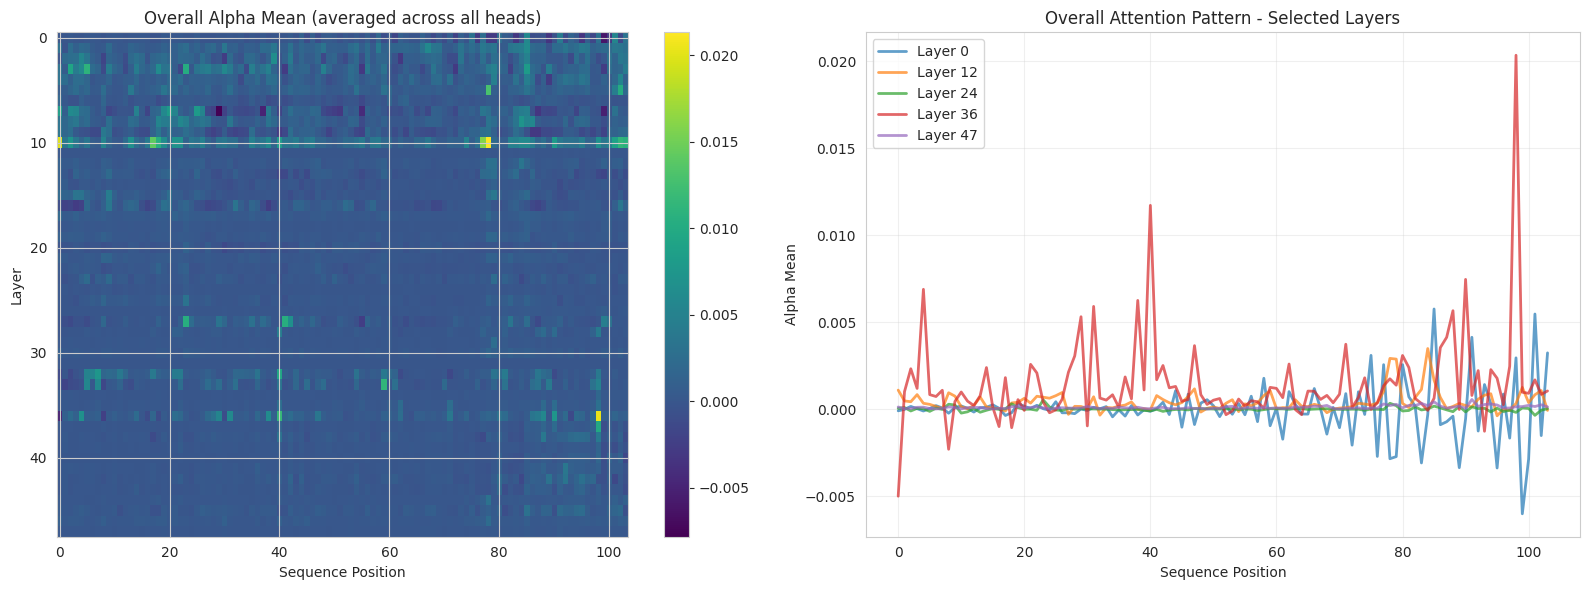

Saved: ./experiments/alpha_stats_full_07090749_overall_pattern.png


In [ ]:
# Average across all heads and headdims: [n_layer, seqlen]
alpha_overall = alpha_mean.mean(dim=(2, 3)).numpy()

# Plot overall attention pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = axes[0].imshow(alpha_overall, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Layer')
axes[0].set_title('Overall Alpha Mean (averaged across all heads)')
plt.colorbar(im, ax=axes[0])

# Line plot for selected layers
for layer in selected_layers:
    axes[1].plot(alpha_overall[layer, :], label=f'Layer {layer}', alpha=0.7, linewidth=2)

axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Alpha Mean')
axes[1].set_title('Overall Attention Pattern - Selected Layers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_overall_pattern.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_overall_pattern.png")

## 6. Multi-Head Attention Comparison

Compare attention patterns across different heads for a specific layer.

Analyzing layer 24


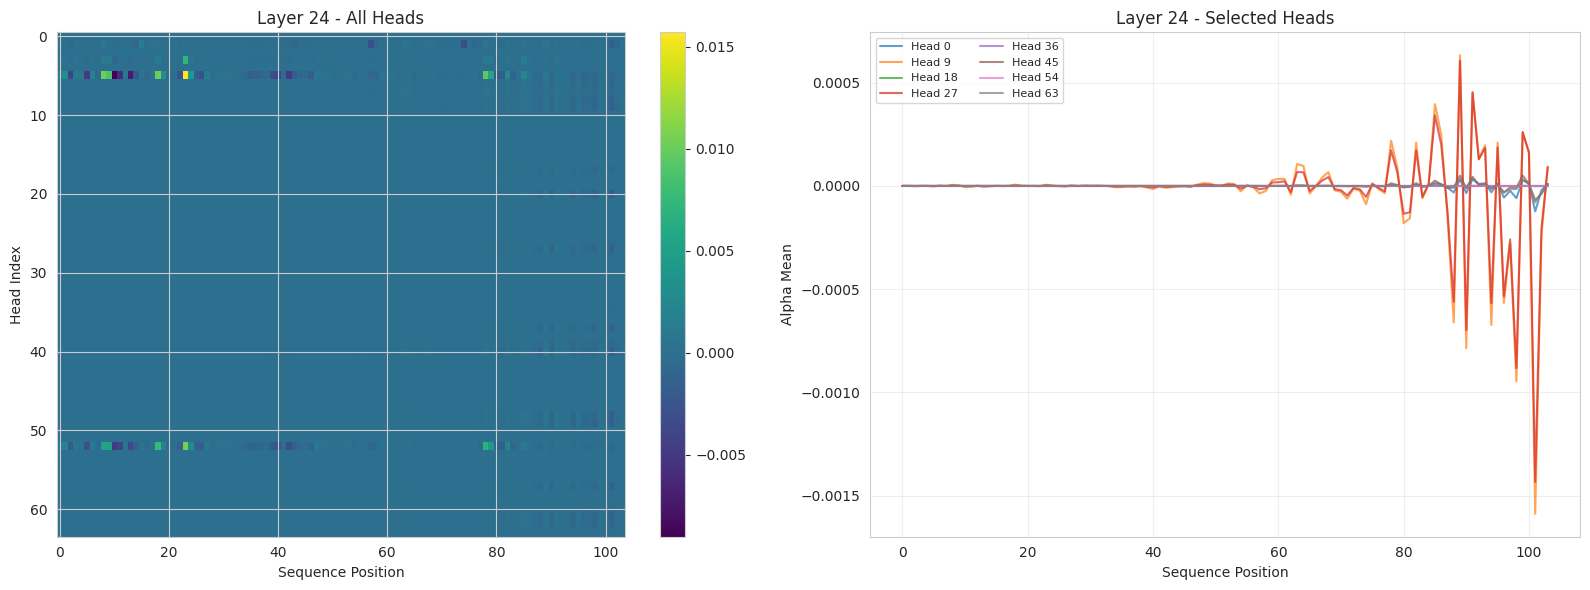

Saved: ./experiments/alpha_stats_full_07090749_multihead_layer24.png


In [ ]:
# Select a middle layer
target_layer = n_layer // 2
print(f"Analyzing layer {target_layer}")

# Get data for this layer: [seqlen, nheads, headdim]
layer_alpha = alpha_mean[target_layer].numpy()
layer_alpha_avg = layer_alpha.mean(axis=-1)  # [seqlen, nheads]

# Plot heatmap showing all heads
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap: heads vs sequence position
im = axes[0].imshow(layer_alpha_avg.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Head Index')
axes[0].set_title(f'Layer {target_layer} - All Heads')
plt.colorbar(im, ax=axes[0])

# Select some heads to plot as lines
heads_to_plot = np.linspace(0, nheads-1, min(8, nheads), dtype=int)
for head in heads_to_plot:
    axes[1].plot(layer_alpha_avg[:, head], label=f'Head {head}', alpha=0.7)

axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Alpha Mean')
axes[1].set_title(f'Layer {target_layer} - Selected Heads')
axes[1].legend(fontsize=8, ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_multihead_layer{target_layer}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_multihead_layer{target_layer}.png")

## 7. Layer-wise Statistics

Analyze how attention patterns evolve across layers.

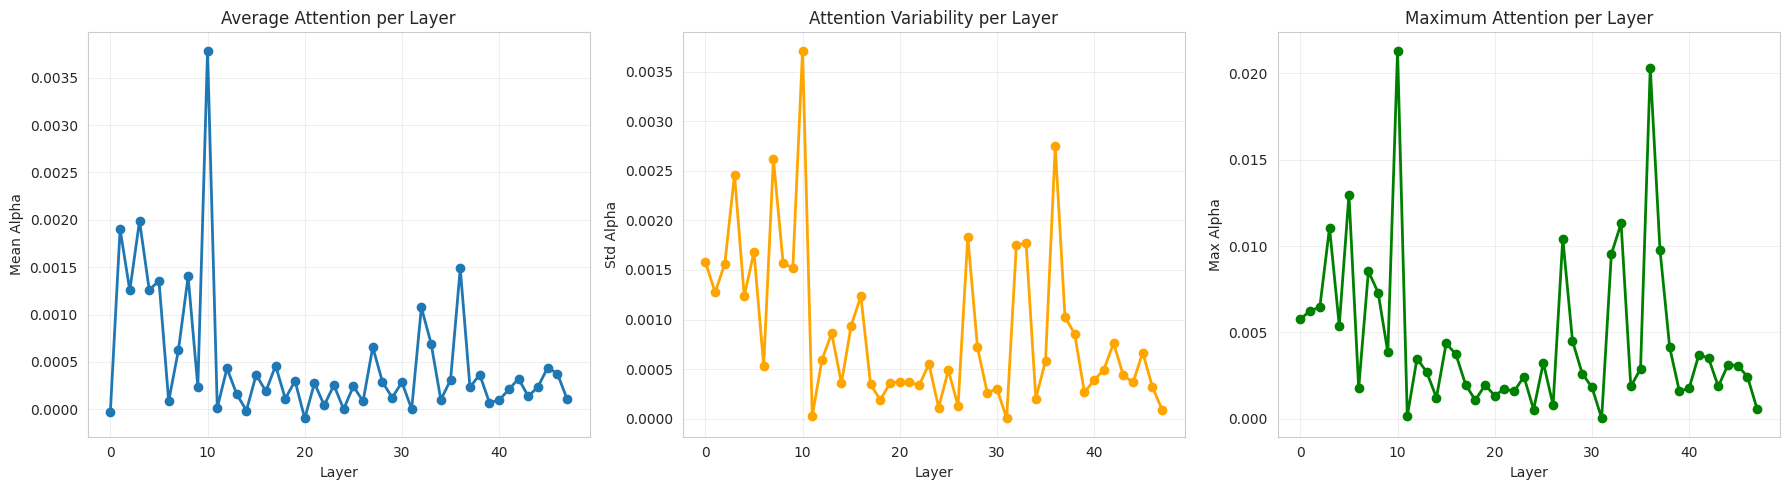

Saved: ./experiments/alpha_stats_full_07090749_layer_statistics.png


In [ ]:
# Calculate statistics for each layer
layer_mean = alpha_overall.mean(axis=1)  # Average attention per layer
layer_std = alpha_overall.std(axis=1)    # Variability per layer
layer_max = alpha_overall.max(axis=1)    # Max attention per layer

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean attention
axes[0].plot(layer_mean, marker='o', linewidth=2)
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Mean Alpha')
axes[0].set_title('Average Attention per Layer')
axes[0].grid(True, alpha=0.3)

# Standard deviation
axes[1].plot(layer_std, marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Std Alpha')
axes[1].set_title('Attention Variability per Layer')
axes[1].grid(True, alpha=0.3)

# Max attention
axes[2].plot(layer_max, marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Layer')
axes[2].set_ylabel('Max Alpha')
axes[2].set_title('Maximum Attention per Layer')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_layer_statistics.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir}_layer_statistics.png")